# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Reducer-Joins" data-toc-modified-id="Reducer-Joins-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Reducer Joins</a></div><div class="lev2 toc-item"><a href="#A-slightly-modified-version-that-works-with-the-HW5.1-toy-dataset,-as-well-as-contains-explanations" data-toc-modified-id="A-slightly-modified-version-that-works-with-the-HW5.1-toy-dataset,-as-well-as-contains-explanations-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>A slightly modified version that works with the HW5.1 toy dataset, as well as contains explanations</a></div><div class="lev2 toc-item"><a href="#Sligthly-modified-version-that-works-with-the-HW5.2-msweb-dataset" data-toc-modified-id="Sligthly-modified-version-that-works-with-the-HW5.2-msweb-dataset-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Sligthly modified version that works with the HW5.2 msweb dataset</a></div>

# Reducer Joins

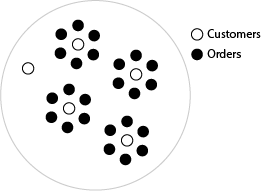

In [117]:
from IPython.display import Image
Image("join-customers-orders.png")

In [118]:
%%writefile customers.dat
1|Alice Bob|31|CA
2|Sam Sneed|51|NV
3|Jon Sneed|37|CA
4|Arnold Wesise|17|NY
5|Henry Bob|25|NV
6|Yo Yo Ma|37|NY
7|Jon York|41|WA
8|Alex Ball|26|WA
9|Jim Davis|19|CA

Overwriting customers.dat


In [119]:
%%writefile orders.dat
1|Apple
3|Garlic
2|Milk
1|Iphone
4|Ipad
5|Book
7|Potato
8|Tomato
9|Orange
5|shoes

Overwriting orders.dat


In [126]:
%%writefile ReducerSideJoins.py

import sys, os, re
from mrjob.job import MRJob

class MRJoin(MRJob):
  # Data will be sorted by key (the customer id), nd then by value:
  # Performs secondary sort on the value starting with either 'A' or 'B'
  SORT_VALUES = True

  def mapper(self, _, line):
    splits = line.rstrip("\n").split("|")

    if len(splits) == 4: # customers
      table = 'A' # make customers sort before orders data
      cid = splits[0]
      yield cid, (table, splits)
    else: # orders
      table = 'B'
      cid = splits[0]
      yield cid, (table, splits)

  def reducer(self, key, values):
    for value in values:
      # customer should come first, as customers are sorted on artificial key 'A'. 
      # Also, we assume that custmer id is a unique identifier
      if value[0] == 'A':
        customer=value[1:][0][1:]
      if value[0] == 'B' and customer:
        transaction=value[1:][0][1:]
        yield key, customer + transaction

class MRLeftJoin(MRJoin):
  def reducer(self, key, values):
    transactionSeen = False
    for value in values:
      if value[0] == 'A': 
        customer=value[1:][0][1:]
      if value[0] == 'B' and customer: 
        transactionSeen = True
        transaction=value[1:][0][1:]
        yield key, customer + transaction   
    if not transactionSeen and customer:
        yield key, customer+[None]
    
class MRRightJoin(MRJoin):
  def reducer(self, key, values):
    for value in values:
      if value[0] == 'A':
        customer=value[1:][0][1:]
      if value[0] == 'B':
        transaction=value[1:][0][1:]
        if customer:
            yield key, customer + transaction      
        else:
            yield "Unknown Customer", transaction
                
    
if __name__ == '__main__':
  MRJoin.run()

Overwriting ReducerSideJoins.py


In [127]:
from ReducerSideJoins import MRJoin, MRLeftJoin, MRRightJoin

for join_type in [MRJoin, MRLeftJoin, MRRightJoin]:
    mr_job = join_type(["customers.dat", "orders.dat"])    
    with mr_job.make_runner() as runner:
        runner.run()
        counter = 0
        for line in runner.stream_output():
            counter += 1
            key, value = mr_job.parse_output_line(line)
            print key, value
            
        className=str(mr_job).split(".")[1].split(" ")[0]    
        print '"%s" : %d rows\n' % (className, counter)

1 ['Alice Bob', '31', 'CA', 'Apple']
1 ['Alice Bob', '31', 'CA', 'Iphone']
2 ['Sam Sneed', '51', 'NV', 'Milk']
3 ['Jon Sneed', '37', 'CA', 'Garlic']
4 ['Arnold Wesise', '17', 'NY', 'Ipad']
5 ['Henry Bob', '25', 'NV', 'Book']
5 ['Henry Bob', '25', 'NV', 'shoes']
7 ['Jon York', '41', 'WA', 'Potato']
8 ['Alex Ball', '26', 'WA', 'Tomato']
9 ['Jim Davis', '19', 'CA', 'Orange']
"MRJoin" : 10 rows

1 ['Alice Bob', '31', 'CA', 'Apple']
1 ['Alice Bob', '31', 'CA', 'Iphone']
2 ['Sam Sneed', '51', 'NV', 'Milk']
3 ['Jon Sneed', '37', 'CA', 'Garlic']
4 ['Arnold Wesise', '17', 'NY', 'Ipad']
5 ['Henry Bob', '25', 'NV', 'Book']
5 ['Henry Bob', '25', 'NV', 'shoes']
6 ['Yo Yo Ma', '37', 'NY', None]
7 ['Jon York', '41', 'WA', 'Potato']
8 ['Alex Ball', '26', 'WA', 'Tomato']
9 ['Jim Davis', '19', 'CA', 'Orange']
"MRLeftJoin" : 11 rows

1 ['Alice Bob', '31', 'CA', 'Apple']
1 ['Alice Bob', '31', 'CA', 'Iphone']
2 ['Sam Sneed', '51', 'NV', 'Milk']
3 ['Jon Sneed', '37', 'CA', 'Garlic']
4 ['Arnold Wesise', '17'

## A slightly modified version that works with the HW5.1 toy dataset, as well as contains explanations

In [128]:
%%writefile ReducerSideJoins.py

import sys, os, re
from mrjob.job import MRJob

class MRJoin(MRJob):
  # Data will be sorted by key (the country id), nd then by value:
  # Performs secondary sort on the value starting with either 'A' or 'B'
  SORT_VALUES = True

  def mapper(self, _, line):
    splits = line.rstrip("\n").split("|")

    if len(splits) == 2: # countries
      table = 'A' # make countries sort before transactions data
      cid = splits[1]
      yield cid, (table, splits)
    else: # transactions
      table = 'B'
      cid = splits[2]
      yield cid, (table, splits)

  def reducer(self, key, values):
    country = [None]
    for value in values:
      # country should come first, as countries are sorted on artificial key 'A'. 
      # Also, we assume that country id is a unique identifier
      if value[0] == 'A':
        country=value[1:]
      if value[0] == 'B' and country[0] is not None:
        transaction=value[1:]
        yield key, country + transaction

class MRLeftJoin(MRJoin):
  
  #####################################################################
  # For a Left-Join we want to make sure that we are not emitting any 
  # rows where there is no row in the left table, hence this check: 
  # "and country[0] is not None"
  #####################################################################
  
  
  def reducer(self, key, values):
    
    ##################################################################
    # transactionSeen = False
    #
    # keeps track of whether the transaction has been seen, in other 
    # words, whether there is an entry in the right table 'B'. This 
    # makes the reducer stateful, but only using a single value, 
    # so it is not a memory concern.
    ##################################################################
    
    transactionSeen = False
    
    ##################################################################
    # country = [None]
    #
    # initialize the country to None. Wrap 'None' in a list for  
    # convenience so we can concatenate the country and transaction 
    # lists thus avoiding ugly string manipulation
    ##################################################################
    
    country = [None]
    
    for value in values:
      if value[0] == 'A': 
        country=value[1:]
      if value[0] == 'B' and country[0] is not None: 
        transactionSeen = True
        transaction=value[1:]
        yield key, country + transaction
    if transactionSeen == False and country[0] is not None:
        yield key, country + [None]
    
class MRRightJoin(MRJoin):
  
  #################################################################
  # For a Right-Join we want to make that we are not emitting any 
  # rows where there is no row in the right table, hence this check:
  # we only yield a row if we come across a transaction.
  #################################################################
  
  def reducer(self, key, values):
    country = [None]
    for value in values:
      if value[0] == 'A':
        country=value[1:]
      if value[0] == 'B':
        transaction=value[1:]
        yield key, country + transaction
    
if __name__ == '__main__':
  MRJoin.run()

Overwriting ReducerSideJoins.py


In [1]:
from ReducerSideJoins import MRJoin, MRLeftJoin, MRRightJoin

for join_type in [MRJoin, MRLeftJoin, MRRightJoin]:
    mr_job = join_type(["countries.dat", "transactions.dat"])    
    with mr_job.make_runner() as runner:
        runner.run()
        counter = 0
        for line in runner.stream_output():
            counter += 1
            key, value = mr_job.parse_output_line(line)
            print key, value
            
        className=str(mr_job).split(".")[1].split(" ")[0]    
        print '"%s" : %d rows\n' % (className, counter)

CA [['Canada', 'CA'], ['Jon Sneed', '$20', 'CA']]
CA [['Canada', 'CA'], ['Jon York', '$44', 'CA']]
CA [['Canada', 'CA'], ['Sam Sneed', '$1', 'CA']]
CA [['Canada', 'CA'], ['Yo Yo Ma', '$2', 'CA']]
UK [['United Kingdom', 'UK'], ['Alex Ball', '$5', 'UK']]
UK [['United Kingdom', 'UK'], ['Arnold Wesise', '$400', 'UK']]
US [['United States', 'US'], ['Alice Bob', '$10', 'US']]
US [['United States', 'US'], ['Henry Bob', '$2', 'US']]
"MRJoin" : 8 rows

CA [['Canada', 'CA'], ['Jon Sneed', '$20', 'CA']]
CA [['Canada', 'CA'], ['Jon York', '$44', 'CA']]
CA [['Canada', 'CA'], ['Sam Sneed', '$1', 'CA']]
CA [['Canada', 'CA'], ['Yo Yo Ma', '$2', 'CA']]
IT [['Italy', 'IT'], None]
UK [['United Kingdom', 'UK'], ['Alex Ball', '$5', 'UK']]
UK [['United Kingdom', 'UK'], ['Arnold Wesise', '$400', 'UK']]
US [['United States', 'US'], ['Alice Bob', '$10', 'US']]
US [['United States', 'US'], ['Henry Bob', '$2', 'US']]
"MRLeftJoin" : 9 rows

CA [['Canada', 'CA'], ['Jon Sneed', '$20', 'CA']]
CA [['Canada', 'CA'], [

## Sligthly modified version that works with the HW5.2 msweb dataset

<img src="http://www.candpgeneration.com/images/JOINS.png" style="float:left">

In [2]:
!head urls-msweb.csv
!wc -l urls-msweb.csv

A,1287,1,International AutoRoute,/autoroute
A,1288,1,library,/library
A,1289,1,Master Chef Product Information,/masterchef
A,1297,1,Central America,/centroam
A,1215,1,For Developers Only Info,/developer
A,1279,1,Multimedia Golf,/msgolf
A,1239,1,Microsoft Consulting,/msconsult
A,1282,1,home,/home
A,1251,1,Reference Support,/referencesupport
A,1121,1,Microsoft Magazine,/magazine
     294 urls-msweb.csv


In [3]:
!head customers-msweb.csv
!wc -l customers-msweb.csv

V,1000,1,C,10001
V,1001,1,C,10001
V,1002,1,C,10001
V,1001,1,C,10002
V,1003,1,C,10002
V,1001,1,C,10003
V,1003,1,C,10003
V,1004,1,C,10003
V,1005,1,C,10004
V,1006,1,C,10005
   98654 customers-msweb.csv


In [1]:
%%writefile ReducerSideJoinsMSWEB.py

import sys, os, re
from mrjob.job import MRJob

class MRJoin(MRJob):
  # Data will be sorted by key (the customer id), and then by value:
  # Performs secondary sort on the value starting with either 'A' or 'V'
  # fortuitously, the data already contains 'A' and 'V', so there is no need to prepend keys.
  SORT_VALUES = True

  def mapper(self, _, line):
    splits = line.rstrip("\n").split(",")
    cid = splits[1]
    yield cid, (splits[0], splits)

  def reducer(self, key, values):
    for value in values:
      leftTBL = [None]
      if value[0] == 'A':
        leftTBL=value[1:]
      if value[0] == 'V':
        rightTBL=value[1:]
        yield key, leftTBL + rightTBL

class MRLeftJoin(MRJoin):
  def reducer(self, key, values):
    transactionSeen = False
    leftTBL = [None]
    for value in values:
      if value[0] == 'A': 
        leftTBL=value[1:]
      if value[0] == 'V' and leftTBL[0] is not None: 
        transactionSeen = True
        rightTBL=value[1:]
        yield key, leftTBL + rightTBL   
    if not transactionSeen and leftTBL[0] is not None:
        yield key, leftTBL+[None]
    
class MRRightJoin(MRJoin):
  def reducer(self, key, values):
    leftTBL = [None]
    for value in values:
      if value[0] == 'A':
        leftTBL=value[1:]
      if value[0] == 'V':
        rightTBL=value[1:]
        yield key, leftTBL + rightTBL      

                
    
if __name__ == '__main__':
  MRJoin.run()

Overwriting ReducerSideJoinsMSWEB.py


In [2]:
from ReducerSideJoinsMSWEB import MRJoin, MRLeftJoin, MRRightJoin

for join_type in [MRJoin, MRLeftJoin, MRRightJoin]:
    mr_job = join_type(["urls-msweb.csv", "customers-msweb.csv"])    
    with mr_job.make_runner() as runner:
        runner.run()
        counter = 0
        for line in runner.stream_output():
            counter += 1
            key, value = mr_job.parse_output_line(line)
#             print key, value # don't print, you will prob crash jupyter UI
            
        className=str(mr_job).split(".")[1].split(" ")[0]    
        print '"%s" : %d rows\n' % (className, counter)

"MRJoin" : 98654 rows

"MRLeftJoin" : 98663 rows

"MRRightJoin" : 98654 rows

